# Integration of Tabula Muris Senis 10X Data

For our integrated dataset, we seek to obtain cell type-averaged counts from the Tabula Muris Senis dataset of `1m, 3m, 18m, 21m, 24m, 30m` mice ([The Tabula Muris Consortium, 2020](https://doi.org/10.1038/s41586-020-2496-1)).

For the dataset integration, we assume the authors have performed satisfactory quality control on cells. We will also take all genes from the raw data so that we can maximize on the number of genes in the integrated dataset, since we take the intersection of genes. Finally, for reasonable comparison, we will normalize all cells to have the same total counts, `1e4`.

In [3]:
import numpy as np
import scanpy as sc
import scipy as sp
import pandas as pd
import seaborn as sb

import module as md

datadir = '../../data/raw_data/sc_data/tms_facs/'
resdir = '../../data/processed_data/sc_data/tms_facs/'

We use the processed h5ad file (which contain the raw counts as well) from [here](https://figshare.com/articles/dataset/Processed_files_to_use_with_scanpy_/8273102?file=23937842).

In [ ]:
file_name = "tabula-muris-senis-facs-processed-official-annotations.h5ad"
adata = sc.read_h5ad(datadir + file_name)

adata

We seek to subset the cells into groups for the merged dataset. The object contains samples from `1m, 3m, 18m, 21m, 24m, 30m` mice. Moreover, the `cell_ontology_class` label does not distinguish between cells of the same class being in different organs, so we also subset cells on the `tissue` class.

Moreover, to not give weight to very small cell type populations, we filter for cell types containing more than 30 cells.

In [3]:
# Groupby the three subsetting categories
df_filt = pd.DataFrame(adata.obs.groupby(["age", "tissue", "cell_ontology_class"]).size())
df_filt = df_filt.rename(columns = {0: "ncells"})
df_filt = df_filt[df_filt["ncells"] > 0].reset_index()

# Drop the cell types with fewer than 30 counts.
df_filt = df_filt[df_filt["ncells"] >= 30]
df_filt = df_filt.drop(columns="ncells")

# Display counts of cell types in each timepoint.
df_filt.value_counts("age")

age
18m    107
30m    100
21m     95
3m      95
1m      69
24m     56
dtype: int64

In [4]:
# Subset the AnnData object to only include cells that are in the subsetted cell types.
keys = list(df_filt.columns.values)
i1 = adata.obs.set_index(keys).index
i2 = df_filt.set_index(keys).index

adata = adata[adata.obs[i1.isin(i2)].index,:]

adata

/Users/niveditakanrar/opt/anaconda3/envs/surf_env2/lib/python3.8/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


View of AnnData object with n_obs × n_vars = 242642 × 20138
    obs: 'age', 'cell', 'cell_ontology_class', 'cell_ontology_id', 'free_annotation', 'method', 'mouse.id', 'n_genes', 'sex', 'subtissue', 'tissue', 'tissue_free_annotation', 'n_counts', 'louvain', 'leiden'
    var: 'n_cells', 'means', 'dispersions', 'dispersions_norm', 'highly_variable'
    uns: 'age_colors', 'leiden', 'louvain', 'louvain_colors', 'neighbors', 'pca', 'tissue_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

### Data Before Processing <a class="anchor" id="2-bullet"></a>

Though we do not perform quality control on cells or genes, we will visualize basic statistics on these parameters to get a rough idea of the data quality.

Trying to set attribute `.obs` of view, copying.
/Users/niveditakanrar/opt/anaconda3/envs/surf_env2/lib/python3.8/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])


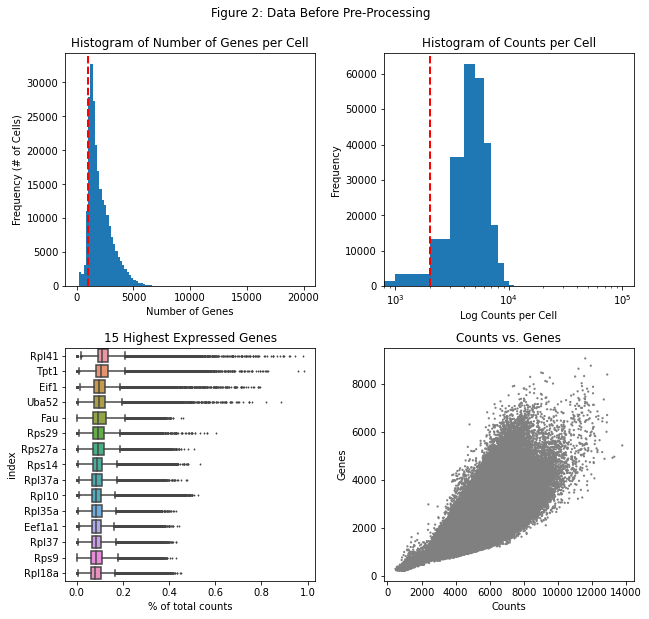

CPU times: user 59.1 s, sys: 2min 26s, total: 3min 25s
Wall time: 4min 40s


In [5]:
%%time

# Below, we display cells with genes/cell and counts/cell, for genes that 
# have at least one 1 count in any cell. 
sc.pp.filter_cells(adata, min_genes=0)
sc.pp.filter_genes(adata, min_cells=0)

# Set annotations to the AnnData object for total counts, cells per gene, and mitochondrial genes
#X = np.matrix(adata.X)
adata.obs['n_total_counts_per_cell'] = adata.X.sum(axis=1)
adata.var['n_cells_per_gene'] = adata.X.astype(bool).astype(int).sum(axis=0).T
adata.obs['n_genes_per_cell'] = adata.X.astype(bool).astype(int).sum(axis=1)

# Make plots to visualize data quality.

pre_processed = md.vis_pre_processing(adata, genes_range=(0, 20000),
    counts_range=(0, 1e5),title='Figure 2: Data Before Pre-Processing',
                                     genes_threshold = 1000, counts_threshold=2000)

In [6]:
avg_genes = int(np.average(adata.obs['n_genes_per_cell']))
avg_counts = int(np.average(adata.obs['n_total_counts_per_cell']))

print('The average number of genes per cell is ' + str(avg_genes) 
      + ' and the average number of counts per cell is ' 
      + str(avg_counts))

The average number of genes per cell is 2045 and the average number of counts per cell is 5120


### Data Normalization <a class="anchor" id="3-bullet"></a>

We normalize the data such that all cells have `1e4` cells.

In [7]:
%%time

# Normalize the data
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

# We set the raw attribute of our AnnData object as the normalized count matrix. 
adata.raw=adata

CPU times: user 9.49 s, sys: 6.37 s, total: 15.9 s
Wall time: 19.8 s


For the integrated atlas, we will now average gene counts over cell types, add metadata, and save the result as csvs, separate for each timepoint.

In [8]:
# Save data separately for each time point.
time_pts = adata.obs["age"].unique()

for age in time_pts:
    
    adata_sub = adata[adata.obs["age"] == age].copy()
    df = pd.DataFrame(index = df_filt[df_filt["age"] == age].index, columns = adata.var.index)
    
    for j in df_filt[df_filt["age"] == age].index:
        df.loc[j] = adata_sub[(adata_sub.obs["tissue"] == df_filt.loc[j, "tissue"]) & 
                              (adata_sub.obs["cell_ontology_class"] == df_filt.loc[j, "cell_ontology_class"])][:, :].X.mean(0)
    
    df["cell_ontology_class"] = df_filt[df_filt["age"] == age]["cell_ontology_class"]
    df["tissue"] = df_filt[df_filt["age"] == age]["tissue"]
    df["dataset"] = age + " 10x"
    
    df.to_csv(resdir + "tabula_muris_senis_" + age + "_all_genes.csv")

/Users/niveditakanrar/opt/anaconda3/envs/surf_env2/lib/python3.8/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


In [9]:
%load_ext watermark
%watermark -v -p numpy,pandas,scanpy,jupyterlab

Python implementation: CPython
Python version       : 3.8.5
IPython version      : 7.17.0

numpy     : 1.18.5
pandas    : 1.1.0
scanpy    : 1.5.1
jupyterlab: 2.2.4

